In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from scipy.interpolate import griddata
import pyproj
from pyproj import Transformer
from datetime import datetime, timedelta
import os, fnmatch, glob
import cmocean 
import rasterio
from rasterio.plot import show

/home/maltem/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [135]:
date = datetime.strptime('2024-04-12 10:00:00','%Y-%m-%d %H:%M:%S') 

# Load visible MODIS satellite image
datetime_str = datetime.strftime(date, '%Y-%m-%d')
geotiff_path = 'data/snapshot-'+datetime_str+'T00_00_00Z.tif'

# Load MODIS skin temperture
istmodis_path= '/lustre/storeB/users/maltem/SALIENSEAS/SvalMIZ2024/observations/remotesensing/aa-modis-2024.nc'
istIn = xr.open_mfdataset(istmodis_path)


# Load SeaIce             -----------------------------------#
dir_seaiceproduct_hres= '/lustre/storeB/project/fou/hi/oper/barents_eps/archive/obs/'
file_name_stub         = 'barents_icec-obs_%s' #barents_icec-obs_20240415T00Z.nc
datetime_str = datetime.strftime(date, '%Y%m%d')
file_prename = file_name_stub % datetime_str
infile_name = glob.glob(dir_seaiceproduct_hres + file_prename + '*.nc')
if infile_name:
    IceIn = xr.open_mfdataset(infile_name)
    lats = np.array(IceIn['lat'])
    lons = np.array(IceIn['lon'])
    sicn = np.array(IceIn['ice_conc'])
    sicn=np.squeeze(np.where(sicn<0.1,np.nan,sicn))

    
#Load OMB data
OMBraw = xr.open_mfdataset('data/cruise/2024_KVS_deployment.nc')    

In [1]:
aist=istIn.sel(time=date,method='nearest')
plt.imshow(np.flip(np.array(a.modis_sist),axis=0))

NameError: name 'istIn' is not defined

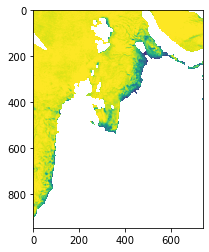

In [137]:
plt.imshow(sicn)

In [138]:
with rasterio.open(geotiff_path, 'r') as src:
    raster_crs = src.crs
    print(raster_crs)
    left, bottom, right, top = src.bounds
    landsat = src.read()[0, :, :]
    landsat = np.ma.masked_where(landsat <= 0,
                                 landsat,
                                 copy=True)
    landsat = (landsat - np.min(landsat)) / (np.max(landsat) - np.min(landsat))                                                                              

EPSG:3413


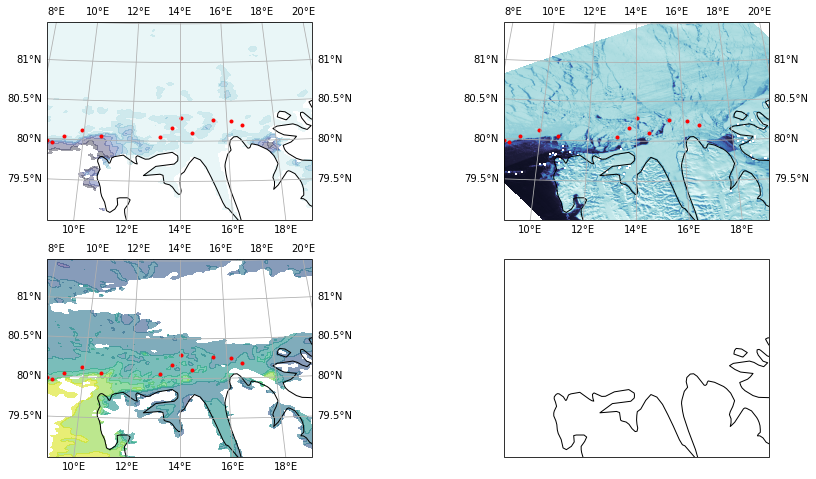

In [150]:
# Create the projection
plot_proj = ccrs.Orthographic(14,25)

fig, ax = plt.subplots(figsize=(15, 8),nrows=2,ncols=2,
                       subplot_kw={'projection': plot_proj})

for i in range(2):
    for j in range(2):
        ax[i,j].coastlines(resolution='50m')
        ax[i,j].set_extent([9, 19, 79., 81.5], crs=ccrs.PlateCarree())

# -- Subplot - 1- #
#    AMSR2 sea-ice contour
contour1 = ax[0,0].contourf(lons, lats, sicn, transform=ccrs.PlateCarree(), cmap=cmocean.cm.ice,alpha=0.4)

# -- Subplot - 2- #
#    MODIS infrared surface temperature
contour2 = ax[1,0].contourf(lons, lats, np.flip(np.array(a.modis_sist),axis=0), transform=ccrs.PlateCarree(),alpha=.6)

# -- Subplot - 3- #
#    MODIS visible satellite picture
contour3 = ax[0,1].imshow(landsat, transform=ccrs.epsg(3413),cmap=cmocean.cm.ice,extent=(left, right, bottom, top))



#Plot the buoy trajectories
#timenow = np.datetime64(date)
#timemask = np.int32(np.abs(np.array(OMBraw.time-timenow)).astype('timedelta64[m]'))<10

startdate = date
timesteps_to_loop=24*3
timesteps_to_loop=1

for dt in range(timesteps_to_loop): #MAKE LOOP
    date = startdate + timedelta(hours=dt*1)
    #------------------------------------------------------------#
    #Find all buoys at date times closer than 29 minutes
    timenow = np.datetime64(date)
    timemask = np.int32(np.abs(np.array(OMBraw.time-timenow)).astype('timedelta64[m]'))<10

    for buoy_no in range(np.min(np.shape(timemask))):
        tb = np.where(timemask[buoy_no,:]); #tb = [x[0] for x in tb1]
        if tb:
            ax[0,0].scatter(OMBraw.lon[buoy_no,np.array(tb[0])],OMBraw.lat[buoy_no,np.array(tb[0])],color='r',marker='.',transform = ccrs.PlateCarree())
            ax[1,0].scatter(OMBraw.lon[buoy_no,np.array(tb[0])],OMBraw.lat[buoy_no,np.array(tb[0])],color='r',marker='.',transform = ccrs.PlateCarree())
            ax[0,1].scatter(OMBraw.lon[buoy_no,np.array(tb[0])],OMBraw.lat[buoy_no,np.array(tb[0])],color='r',marker='.',transform = ccrs.PlateCarree())


# Add color bar
#cbar = plt.colorbar(contour1, ax=ax[0,0], orientation='horizontal', pad=0.05)
#cbar.set_label('Variable Units')  # Replace with the actual units of your variable

# Add gridlines and labels
ax[0,0].gridlines(draw_labels=True)
ax[1,0].gridlines(draw_labels=True)
ax[0,1].gridlines(draw_labels=True)
# Display the plot
plt.show()

In [ ]:
# MODIS IST should be shown in a +- 4hour window
# Sentinel-2 ? Sentinel-3?

